Interactively figure out MGRS tiles and track numbers

In [18]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt

# Load Event Data

In [19]:
yaml_file = 'marshak/L_ad_hoc_data_generation/events/park_fire_2024.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'park_fire_2024',
 'bounds': [-122.063588, 39.770975, -121.49483901, 40.394684],
 'event_date': '2024-07-24',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [137, 115],
 'mgrs_tiles': ['10TEK', '10TFK'],
 'dist_hls_confirmed_change_min_days': 15,
 'source_id': 'WFIGS Park Fire 2024',
 'links': ['https://en.wikipedia.org/wiki/Park_Fire']}

# Read Geojson

In [20]:
p_json = Path(f'jungkyo/cumsum_algorithm/external_validation_data_db/{event_dict["event_name"]}.geojson')
p_parq = Path(f'jungkyo/cumsum_algorithm/external_validation_data_db/{event_dict["event_name"]}.parquet')
if p_json.exists():
    df_event = gpd.read_file(p_json)
else:
    df_event = gpd.read_parquet(p_parq)

In [21]:
# df_event.plot()

In [22]:
df_event.head()

name       date   source_id  \
0  park_fire_2024 2024-08-12  WFIGS PARK   

                                            geometry  
0  MULTIPOLYGON (((-121.92949 39.97491, -121.9291...

In [23]:
df_event.total_bounds

array([-122.063588  ,   39.770975  , -121.49483901,   40.394684  ])

# Create Spatial AOI

In [24]:
aoi = box(*df_event.total_bounds)
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [25]:
bounds = aoi.bounds
bounds

(-122.06358800099997, 39.770975, -121.49483900699994, 40.394684)

# Find MGRS tiles and Explore

In [26]:
df_mgrs = gpd.read_parquet('jungkyo/cumsum_algorithm/mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.geometry.intersects(aoi)].reset_index(drop=True)
# remove antimeridian
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(-180, -60, -179, 60))]
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(179, -60, 180, 60))]

df_mgrs_overlapping.head()

tile_id    epsg                                            utm_wkt  \
1   10TEK   32610  MULTIPOLYGON(((499980 4500000,499980 4390200,6...   
2   10TFK   32610  MULTIPOLYGON(((600000 4500000,600000 4390200,7...   

                                            geometry  
1  MULTIPOLYGON (((-123.00024 40.65086, -123.0002...  
2  MULTIPOLYGON (((-121.81730 40.64480, -121.8343...

In [27]:
m = df_mgrs_overlapping.explore(column='tile_id', categorical=True)
df_aoi.exterior.explore(m=m, style_kwds={'color':'black'})

# Select MGRS Tile(s)

In [28]:
MGRS_TILES = event_dict['mgrs_tiles']
MGRS_TILES

['10TEK', '10TFK']

In [29]:
df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(MGRS_TILES)].reset_index(drop=True)
search_geo = df_mgrs_search.geometry.unary_union

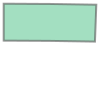

In [30]:
search_geo

# Explore Availability of RTC Data

In [31]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [32]:
resp_pre = asf.geo_search(intersectsWith=search_geo.wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, 
                          start=PRE_DT_START, 
                          end=EVENT_DT)
len(resp_pre)

["'type': 'GEOMETRY_SIMPLIFICATION': 'report': 'Shape Simplified: shape of 10 simplified to 6 with proximity threshold of 0.004'", "'type': 'REVERSE': 'report': Reversed polygon winding order"]


461

In [33]:
resp_post = asf.geo_search(intersectsWith=search_geo.wkt,
                           processingLevel='RTC',
                           platform=asf.constants.SENTINEL1, 
                           start=EVENT_DT, 
                           end=POST_DT_STOP)
len(resp_post)

["'type': 'GEOMETRY_SIMPLIFICATION': 'report': 'Shape Simplified: shape of 10 simplified to 6 with proximity threshold of 0.004'", "'type': 'REVERSE': 'report': Reversed polygon winding order"]


300

In [34]:
df_rtc_resp_pre_e = gpd.GeoDataFrame.from_features(resp_pre.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_pre_e = df_rtc_resp_pre_e[df_rtc_resp_pre_e.pathNumber == 130].reset_index(drop=True)
df_rtc_resp_pre_e['geometry'] = df_rtc_resp_pre_e['geometry'].boundary
m = df_rtc_resp_pre_e.explore(alpha=.1, column='pathNumber', categorical=True, cmap='tab20c')
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)
df_aoi.explore(m=m)
m

In [35]:
df_rtc_resp_pre_e.pathNumber.unique()

array([ 42,  35, 137, 115])

In [36]:
df_rtc_resp_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
# df_rtc_resp_post_e = df_rtc_resp_post_e[df_rtc_resp_post_e.pathNumber.isin([30, 51])].boundary.reset_index(drop=True)
m = df_rtc_resp_post_e.explore()
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)

m

In [37]:
df_rtc_resp_post_e.head()

geometry  centerLat   centerLon  \
0  POLYGON ((-121.18133 39.65087, -122.11097 39.7...  39.626702 -121.662705   
1  POLYGON ((-120.17021 39.57301, -121.22250 39.7...  39.561024 -120.713845   
2  POLYGON ((-121.14839 39.81697, -122.07664 39.9...  39.792598 -121.629157   
3  POLYGON ((-120.12944 39.73857, -121.19245 39.8...  39.727186 -120.678396   
4  POLYGON ((-121.11442 39.98319, -122.04381 40.1...  39.958591 -121.595633   

               stopTime                                             fileID  \
0  2024-09-21T14:07:57Z  OPERA_L2_RTC-S1_T042-088905-IW3_20240921T14075...   
1  2024-09-21T14:07:57Z  OPERA_L2_RTC-S1_T042-088905-IW2_20240921T14075...   
2  2024-09-21T14:07:55Z  OPERA_L2_RTC-S1_T042-088904-IW3_20240921T14075...   
3  2024-09-21T14:07:54Z  OPERA_L2_RTC-S1_T042-088904-IW2_20240921T14075...   
4  2024-09-21T14:07:52Z  OPERA_L2_RTC-S1_T042-088903-IW3_20240921T14074...   

  flightDirection  pathNumber processingLevel  \
0      DESCENDING          42             RTC   
1      DESCENDING          42             RTC   
2      DESCENDING          42             RTC   
3      DESCENDING          42             RTC   
4      DESCENDING          42             RTC   

                                                 url             startTime  \
0  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-09-21T14:07:54Z   
1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-09-21T14:07:53Z   
2  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-09-21T14:07:52Z   
3  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-09-21T14:07:51Z   
4  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-09-21T14:07:49Z   

   ... validityStartDate subswath  \
0  ...              None      IW3   
1  ...              None      IW2   
2  ...              None      IW3   
3  ...              None      IW2   
4  ...              None      IW3   

                                            fileName beamModeType  \
0  OPERA_L2_RTC-S1_T042-088905-IW3_20240921T14075...           IW   
1  OPERA_L2_RTC-S1_T042-088905-IW2_20240921T14075...           IW   
2  OPERA_L2_RTC-S1_T042-088904-IW3_20240921T14075...           IW   
3  OPERA_L2_RTC-S1_T042-088904-IW2_20240921T14075...           IW   
4  OPERA_L2_RTC-S1_T042-088903-IW3_20240921T14074...           IW   

                                              s3Urls beamMode  \
0  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
1  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
2  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
3  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
4  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   

                                      additionalUrls bistaticDelayCorrection  \
0  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
1  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
2  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
3  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
4  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   

  noiseCorrection postProcessingFilter  
0            TRUE                FALSE  
1            TRUE                FALSE  
2            TRUE                FALSE  
3            TRUE                FALSE  
4            TRUE                FALSE  

[5 rows x 33 columns]